In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
dataroot = "../abstract_1/small_abstract"
n_dl_thrds = 3
batch_size = 64
image_size = 128
#num channels = number of color components per pixel
nc = 3
# size of input latent vector
nz = 100
# feature map size for generator
ngf = 32
# feature map size for discriminator
ndf = 32
num_epochs = 500
# learning rate
lr = 0.0003
# see Adam's optimizers for more 
beta1 = 0.5
beta2 = 0.999
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

noise_level = 0.1

In [ ]:
class gen(nn.Module):
    def __init__(self, ngpu):
        super(gen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 16),

            # state size. (ngf*16) x 4 x 4
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 8),

            # state size. (ngf*8) x 8 x 8
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 4),
            # state size. (ngf*4) x 16 x 16 
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 2),
            # state size. (ngf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf),
            # state size. (ngf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False)),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

class disc(nn.Module):
    def __init__(self, ngpu):
        super(disc, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 2),
            
            # state size. (ndf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 4),
            
            # state size. (ndf*4) x 16 x 16 
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 8),
            
            # state size. (ndf*8) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 16),
            
            # state size. (ndf*16) x 4 x 4
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input):
        return self.main(input)

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
#returns generator network only for now
def train_GAN(device, dataloader):
    netG = gen(ngpu).to(device)
    if ((device.type == 'cuda') and (ngpu > 1)):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    netG.apply(weights_init)
    print(netG)
    netD = disc(ngpu).to(device)
    if ((device.type == 'cuda') and (ngpu > 1)):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    netD.apply(weights_init)
    print(netD)
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(128, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
    img_list = []
    img_list_2 = []
    G_losses = []
    D_losses = []
    iters = 0
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            #Update discriminator
            #training it with a batch from training set
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            #pass batch of real images
            output = netD(real_cpu).view(-1)
            #calculate loss
            errD_real = criterion(output, label)
            #calculate gradients
            errD_real.backward()
            D_x = output.mean().item()

            #train discriminator with output from generator
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            #generates batch of fake images
            fake = netG(noise)
            label.fill_(fake_label)
            #classify the generated images
            output = netD(fake.detach()).view(-1)
            #discriminators loss on generated images
            errD_fake = criterion(output, label)
            #gradients for discriminator and sum with gradients from real batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            #updates disc
            optimizerD.step()

            #Update generator
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            #forward pass fake images again through discriminator
            output = netD(fake).view(-1)
            #calculates gen loss on disc pass
            errG = criterion(output, label)
            #gradients for gen
            errG.backward()
            D_G_z2 = output.mean().item()
            #update generator
            optimizerG.step()
            if i % 8 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                vutils.save_image(vutils.make_grid(fake[0], padding=2, normalize=True), 'prog3/'+str(iters)+'image' + str(random.random()) + '.jpg')
            iters += 1
    torch.save({
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict()
        }, 'model_1000.tar')
    return netG

In [19]:
def run():
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=n_dl_thrds)
    dataloader_2 = torch.utils.data.DataLoader(dataset, batch_size=32,
                                             shuffle=True, num_workers=n_dl_thrds)
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    real_batch = next(iter(dataloader_2))
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
    generator = train_GAN(device, dataloader)
    torch.save(generator.state_dict(), 'gen_1_1000.pt')
    for i in range(128):
        noise = torch.randn(128, nz, 1, 1, device=device)
        nn_img = generator(noise).detach().cpu()
        vutils.save_image(vutils.make_grid(nn_img[0], padding=2, normalize=True), 'nnimages_2/z_'+str(i)+'image' + str(random.random()) + '.jpg')

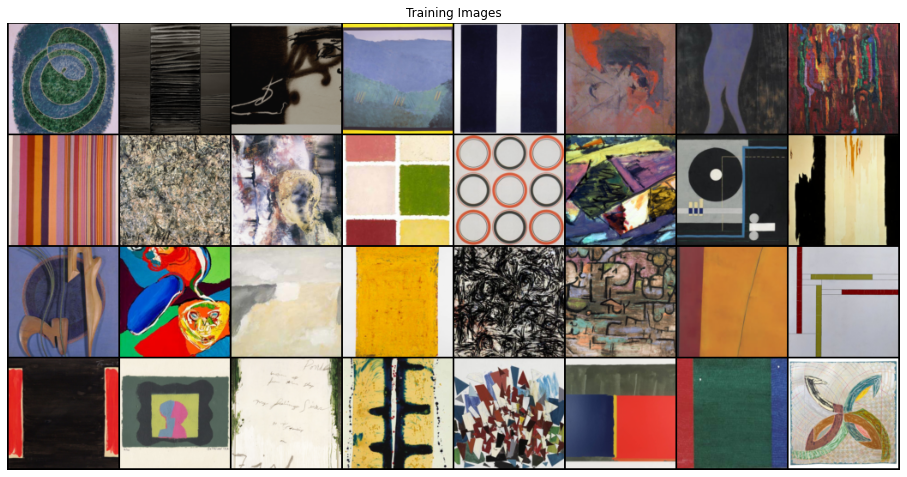

gen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d

[13/500][32/33]	Loss_D: 2.1131	Loss_G: 4.8165	D(x): 0.2872	D(G(z)): 0.0021 / 0.0296
[14/500][0/33]	Loss_D: 0.4267	Loss_G: 1.9172	D(x): 0.8066	D(G(z)): 0.1030 / 0.2627
[14/500][8/33]	Loss_D: 0.4096	Loss_G: 5.0911	D(x): 0.8803	D(G(z)): 0.2121 / 0.0107
[14/500][16/33]	Loss_D: 0.3304	Loss_G: 3.5067	D(x): 0.8222	D(G(z)): 0.0724 / 0.0688
[14/500][24/33]	Loss_D: 0.1380	Loss_G: 4.4759	D(x): 0.9342	D(G(z)): 0.0610 / 0.0152
[14/500][32/33]	Loss_D: 0.2850	Loss_G: 4.6927	D(x): 0.9194	D(G(z)): 0.1453 / 0.0153
[15/500][0/33]	Loss_D: 0.5740	Loss_G: 4.2487	D(x): 0.8098	D(G(z)): 0.2099 / 0.0344
[15/500][8/33]	Loss_D: 0.4831	Loss_G: 3.6096	D(x): 0.8188	D(G(z)): 0.1923 / 0.0393
[15/500][16/33]	Loss_D: 0.8610	Loss_G: 4.7688	D(x): 0.8416	D(G(z)): 0.3943 / 0.0212
[15/500][24/33]	Loss_D: 1.4417	Loss_G: 6.4109	D(x): 0.9535	D(G(z)): 0.6122 / 0.0048
[15/500][32/33]	Loss_D: 0.5814	Loss_G: 2.7678	D(x): 0.7145	D(G(z)): 0.1032 / 0.0866
[16/500][0/33]	Loss_D: 0.4918	Loss_G: 4.3040	D(x): 0.9156	D(G(z)): 0.2801 / 0.02

[33/500][16/33]	Loss_D: 1.4975	Loss_G: 11.2176	D(x): 0.9610	D(G(z)): 0.6527 / 0.0001
[33/500][24/33]	Loss_D: 0.4537	Loss_G: 4.2859	D(x): 0.9603	D(G(z)): 0.2668 / 0.0295
[33/500][32/33]	Loss_D: 1.8837	Loss_G: 11.4146	D(x): 0.9491	D(G(z)): 0.7391 / 0.0001
[34/500][0/33]	Loss_D: 2.9352	Loss_G: 3.5285	D(x): 0.1373	D(G(z)): 0.0038 / 0.1245
[34/500][8/33]	Loss_D: 0.3649	Loss_G: 3.6555	D(x): 0.8103	D(G(z)): 0.0971 / 0.0541
[34/500][16/33]	Loss_D: 0.4817	Loss_G: 5.7536	D(x): 0.9073	D(G(z)): 0.2557 / 0.0061
[34/500][24/33]	Loss_D: 0.6792	Loss_G: 5.0454	D(x): 0.9384	D(G(z)): 0.3609 / 0.0178
[34/500][32/33]	Loss_D: 0.1819	Loss_G: 4.6807	D(x): 0.9337	D(G(z)): 0.0915 / 0.0133
[35/500][0/33]	Loss_D: 0.3118	Loss_G: 4.7900	D(x): 0.9290	D(G(z)): 0.1771 / 0.0154
[35/500][8/33]	Loss_D: 1.0047	Loss_G: 4.4346	D(x): 0.5610	D(G(z)): 0.0146 / 0.0320
[35/500][16/33]	Loss_D: 0.3943	Loss_G: 6.2115	D(x): 0.8607	D(G(z)): 0.1604 / 0.0064
[35/500][24/33]	Loss_D: 0.8007	Loss_G: 7.8786	D(x): 0.5441	D(G(z)): 0.0019 / 0

[53/500][0/33]	Loss_D: 0.5618	Loss_G: 9.2776	D(x): 0.9802	D(G(z)): 0.3452 / 0.0004
[53/500][8/33]	Loss_D: 0.1938	Loss_G: 3.7865	D(x): 0.8958	D(G(z)): 0.0690 / 0.0458
[53/500][16/33]	Loss_D: 0.4212	Loss_G: 5.1058	D(x): 0.7252	D(G(z)): 0.0144 / 0.0382
[53/500][24/33]	Loss_D: 0.1605	Loss_G: 6.7223	D(x): 0.9458	D(G(z)): 0.0842 / 0.0027
[53/500][32/33]	Loss_D: 0.6816	Loss_G: 4.4557	D(x): 0.6360	D(G(z)): 0.0279 / 0.0383
[54/500][0/33]	Loss_D: 0.0848	Loss_G: 3.7901	D(x): 0.9491	D(G(z)): 0.0289 / 0.0490
[54/500][8/33]	Loss_D: 0.1237	Loss_G: 7.5941	D(x): 0.9778	D(G(z)): 0.0890 / 0.0011
[54/500][16/33]	Loss_D: 0.9580	Loss_G: 12.2972	D(x): 0.9865	D(G(z)): 0.4932 / 0.0000
[54/500][24/33]	Loss_D: 1.3017	Loss_G: 13.5144	D(x): 0.9586	D(G(z)): 0.5746 / 0.0000
[54/500][32/33]	Loss_D: 2.4912	Loss_G: 0.2868	D(x): 0.2261	D(G(z)): 0.0020 / 0.7960
[55/500][0/33]	Loss_D: 3.2219	Loss_G: 6.5256	D(x): 0.9997	D(G(z)): 0.8236 / 0.0062
[55/500][8/33]	Loss_D: 0.4517	Loss_G: 6.5153	D(x): 0.9637	D(G(z)): 0.2589 / 0.0

[72/500][24/33]	Loss_D: 0.0483	Loss_G: 6.0998	D(x): 0.9791	D(G(z)): 0.0247 / 0.0061
[72/500][32/33]	Loss_D: 0.4634	Loss_G: 4.4721	D(x): 0.7721	D(G(z)): 0.0120 / 0.0462
[73/500][0/33]	Loss_D: 0.5300	Loss_G: 9.3430	D(x): 0.9483	D(G(z)): 0.3167 / 0.0003
[73/500][8/33]	Loss_D: 0.0848	Loss_G: 5.6035	D(x): 0.9910	D(G(z)): 0.0669 / 0.0100
[73/500][16/33]	Loss_D: 0.4798	Loss_G: 9.4540	D(x): 0.9973	D(G(z)): 0.3106 / 0.0002
[73/500][24/33]	Loss_D: 0.4889	Loss_G: 8.6169	D(x): 0.9910	D(G(z)): 0.2566 / 0.0010
[73/500][32/33]	Loss_D: 0.0742	Loss_G: 5.3999	D(x): 0.9667	D(G(z)): 0.0367 / 0.0139
[74/500][0/33]	Loss_D: 0.6171	Loss_G: 13.1499	D(x): 0.9811	D(G(z)): 0.3183 / 0.0000
[74/500][8/33]	Loss_D: 0.0653	Loss_G: 5.6196	D(x): 0.9710	D(G(z)): 0.0319 / 0.0082
[74/500][16/33]	Loss_D: 0.3891	Loss_G: 3.6100	D(x): 0.8255	D(G(z)): 0.1278 / 0.0610
[74/500][24/33]	Loss_D: 0.2239	Loss_G: 5.0439	D(x): 0.9258	D(G(z)): 0.1110 / 0.0183
[74/500][32/33]	Loss_D: 0.3216	Loss_G: 4.3555	D(x): 0.7735	D(G(z)): 0.0110 / 0.

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 54, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "C:\Users\okell\anaconda3\lib\site-packages\torch\storage.py", line 155, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: falseINTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\MapAllocator.cpp":141, please report a bug to PyTorch. Couldn't map view of shared file <000002B2BE06E8F2>, error code: <5>


In [20]:
if __name__ == '__main__':
    run()

In [ ]:
torch.cuda.empty_cache() 